# Image Classification

## Training the model

In [ ]:
import pandas as pd
import os
import cv2
import numpy as np
import shutil
import random
from sklearn.model_selection import train_test_split
from keras.applications import Xception
from keras.applications.xception import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
main_dir = '/content/drive/My Drive/ImageClassification/'

### To set up the data folders

In [ ]:
from zipfile import ZipFile

zip = ZipFile(main_dir+'tshirt_images_v1.zip',mode='r')
zip.extractall()

KeyboardInterrupt: ignored

In [ ]:
total_ann = []
import json
for i in range(1,35):
   g = open(main_dir+'annotations/annotations_'+str(i)+'.txt','r')
   dataa = g.readlines()
   dataa = dataa[0]
   dataa = json.loads(dataa)['data']
   total_ann+=dataa

In [ ]:
print(len(total_ann))
random.shuffle(total_ann)

3398


In [ ]:
train_ann = total_ann[:int(0.9*(len(total_ann)))]
val_ann = total_ann[int(0.8*(len(total_ann))):int(0.9*(len(total_ann)))]
test_ann = total_ann[int(0.9*(len(total_ann))):]

print("Number of training images",len(train_ann))
print("Number of validation images",len(val_ann))
print("Number of test images",len(test_ann))

Number of training images 3058
Number of validation images 340
Number of test images 340


In [ ]:
if not os.path.exists(main_dir+'tshirt_v2'):
    os.mkdir(main_dir+'tshirt_v2')

ann= [ train_ann, val_ann, test_ann]
folder_names = ['train','val','test']

for i in folder_names:
    if not os.path.exists(main_dir+'tshirt_v2/'+i):
        os.mkdir(main_dir+'tshirt_v2/'+i)

for i in range(3):
    for item in ann[i]:
        if item[1]!='none':
            if not os.path.exists(main_dir+'tshirt_v2/'+folder_names[i]+'/'+item[1]):
                os.mkdir(main_dir+'tshirt_v2/'+folder_names[i]+'/'+item[1])
            image_name = item[0].strip().split('/')[-1]
            shutil.copy(item[0],main_dir+'tshirt_v2/'+folder_names[i]+'/'+item[1]+'/'+image_name)
        else:
            print('Removing example with annotation "none"')

Removing example with annotation "none"
Removing example with annotation "none"


### Start running from here.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
                    preprocessing_function=preprocess_input,
                    horizontal_flip = True,
                    width_shift_range = 0.05,
                    height_shift_range = 0.05
                             )

train_generator = datagen.flow_from_directory(
    directory=main_dir+"tshirt_v2/train/",
    target_size=(400, 400),
    color_mode="rgb",
    batch_size=16,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

val_generator = datagen.flow_from_directory(
    directory=main_dir+"tshirt_v2/val/",
    target_size=(400, 400),
    color_mode="rgb",
    batch_size=16,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

test_generator = datagen.flow_from_directory(
    directory=main_dir+"tshirt_v2/test/",
    target_size=(400, 400),
    color_mode="rgb",
    batch_size=16,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

Found 3054 images belonging to 8 classes.
Found 340 images belonging to 8 classes.
Found 340 images belonging to 8 classes.


In [ ]:
print(train_generator.class_indices)
class_mapping = train_generator.class_indices
import json

with open('/content/drive/My Drive/ImageClassification/tshirt_v2/class_mapping.json','w') as f:
    f.write(json.dumps(train_generator.class_indices))
    f.close()

reverse_class_mapping = {value:key for (key,value) in class_mapping.items()}

{'back': 0, 'close-up': 1, 'cloth': 2, 'collar': 3, 'front': 4, 'full': 5, 'side': 6, 'sleeve': 7}


In [ ]:
import keras

optimizer = keras.optimizers.SGD(lr=1e-2, momentum=0.9, decay=1e-2/10)

METRICS = [
      #keras.metrics.TruePositives(name='tp'),
      #keras.metrics.FalsePositives(name='fp'),
      #keras.metrics.TrueNegatives(name='tn'),
      #keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

model1 = Xception(include_top=True, weights=None, input_tensor=None, input_shape=(400,400,3), pooling=None, classes=8)
model1.compile(loss='categorical_crossentropy', metrics=METRICS,optimizer=optimizer)
model1.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 400, 400, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 199, 199, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 199, 199, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 199, 199, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [ ]:
model2 = model1
model2.layers[-1].bias.assign([0.0]*8)

<tf.Variable 'UnreadVariable' shape=(8,) dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>

In [ ]:
model3 = model1
## by specifying class weights
import numpy as np
import math

# labels_dict : {ind_label: count_label}
# mu : parameter to tune 

def create_class_weight(labels_dict,mu=0.25):
    total = sum(list(labels_dict.values()))
    print(total)
    keys = labels_dict.keys()
    print(keys)
    class_weight = dict()

    for key in keys:
        score = mu*total/float(labels_dict[key])
        # score = math.log(mu*total/float(labels_dict[key]))
        class_weight[key] = score if score > 1.0 else 1.0

    return class_weight

# finding the number of examples in each category
labels_dict = {key:0 for key in range(8)}
for i in ['train','val','test']:
    path = main_dir+'tshirt_v2/'+i
    for j in os.listdir(path):
        labels_dict[class_mapping[j]] =   float(labels_dict[class_mapping[j]] + len(os.listdir(path+'/'+j)) )

print(labels_dict)

class_weights = create_class_weight(labels_dict)

print(class_weights)

{0: 634.0, 1: 313.0, 2: 638.0, 3: 273.0, 4: 967.0, 5: 470.0, 6: 232.0, 7: 207.0}
3734.0
dict_keys([0, 1, 2, 3, 4, 5, 6, 7])
{0: 1.472397476340694, 1: 2.9824281150159746, 2: 1.463166144200627, 3: 3.4194139194139193, 4: 1.0, 5: 1.9861702127659575, 6: 4.023706896551724, 7: 4.509661835748792}


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1,min_lr=1e-7, factor = 0.5)

In [ ]:
history = model3.fit_generator(
    generator = train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[reduce_lr],
    shuffle =True,
    use_multiprocessing=True,
    workers=-1,
    class_weight=class_weights,
)

Epoch 1/10
191/191 [==============================] - 311s 2s/step - loss: 1.1343 - accuracy: 0.9528 - precision: 0.8516 - recall: 0.7538 - auc: 0.9768 - val_loss: 1.6828 - val_accuracy: 0.9518 - val_precision: 0.8426 - val_recall: 0.7559 - val_auc: 0.9626
Epoch 2/10
191/191 [==============================] - 306s 2s/step - loss: 1.1464 - accuracy: 0.9498 - precision: 0.8446 - recall: 0.7331 - auc: 0.9759 - val_loss: 1.9772 - val_accuracy: 0.9507 - val_precision: 0.8411 - val_recall: 0.7471 - val_auc: 0.9624
Epoch 3/10
191/191 [==============================] - ETA: 0s - loss: 1.1005 - accuracy: 0.9523 - precision: 0.8515 - recall: 0.7489 - auc: 0.9776
Epoch 00003: ReduceLROnPlateau reducing learning rate to 4.882812390860636e-06.
191/191 [==============================] - 305s 2s/step - loss: 1.1005 - accuracy: 0.9523 - precision: 0.8515 - recall: 0.7489 - auc: 0.9776 - val_loss: 1.8360 - val_accuracy: 0.9504 - val_precision: 0.8317 - val_recall: 0.7559 - val_auc: 0.9642
Epoch 4/10
19

In [ ]:
model3.save(main_dir+'model3_preprop_35ep.h5')

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'auc', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc', 'lr'])
loss


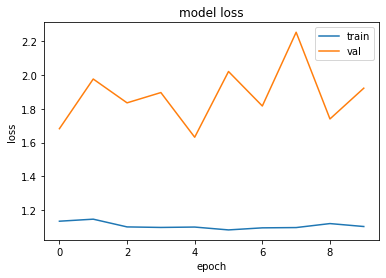

accuracy


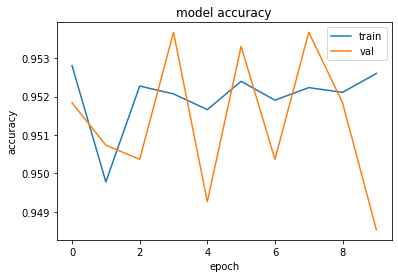

precision


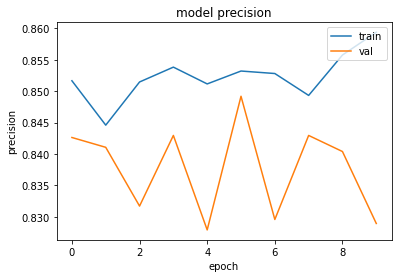

recall


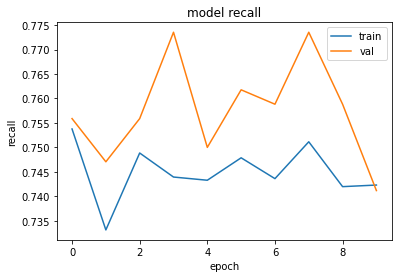

auc


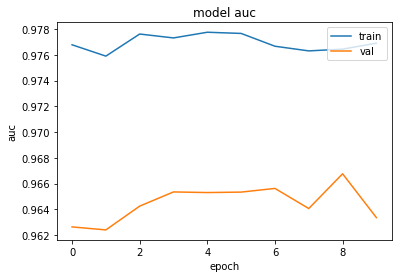

In [ ]:
import matplotlib.pyplot as plt
print(history.history.keys())
 
# summarize history for loss
print('loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

print('accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

print('precision')
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

print('recall')
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

print('auc')
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
scores = model3.evaluate_generator(test_generator) 
print("Accuracy = ", scores)

Accuracy =  [1.5172594785690308, 0.9558823704719543, 0.8666666746139526, 0.7647058963775635, 0.9738303422927856]


In [ ]:
print(scores)

# 'accuracy', 'precision', 'recall', 'auc'

[1.5172594785690308, 0.9558823704719543, 0.8666666746139526, 0.7647058963775635, 0.9738303422927856]


## LIME Model Interpretability

In [ ]:
from keras.models import load_model
main_dir = '/content/drive/My Drive/ImageClassification/'
loaded_model = load_model(main_dir+'model3_20ep.h5')

In [ ]:
!pip install lime
from lime import lime_image
# https://github.com/marcotcr/lime
# https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20Image%20Classification%20Keras.ipynb


     |████████████████████████████████| 276kB 5.7MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp36-none-any.whl size=283845 sha256=3a98ef14d7cfa2b0e17abdadad0603908bb574825b7e32409b5223d33c8e1b87
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


In [ ]:
from skimage.segmentation import mark_boundaries

In [ ]:
import os
test_filenames=[]

for folder in os.listdir(main_dir+'tshirt_v2/test'):
    for item in os.listdir(main_dir+'tshirt_v2/test/'+folder):

        test_filenames.append(os.path.join(main_dir+'tshirt_v2/test/'+folder,item))

<class 'list'>
340
/content/drive/My Drive/ImageClassification/tshirt_v2/test/full/4683_2.jpg
(400, 400, 3)


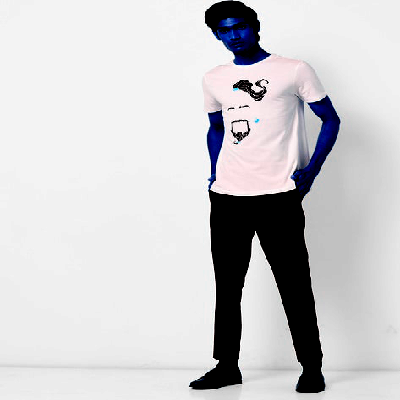

In [ ]:
from keras.preprocessing import image
from keras.applications.xception import preprocess_input
from google.colab.patches import cv2_imshow
import numpy as np

print(type(test_filenames))
print(len(test_filenames))
img_path =test_filenames[5]
print(img_path)
img = image.load_img(img_path, target_size=(400, 400))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
x = x.reshape(400,400,3)
print(x.shape)

cv2_imshow(x*255)

In [ ]:
explainer = lime_image.LimeImageExplainer()
x = x.reshape(400,400,3)
explanation = explainer.explain_instance(x,
                                         loaded_model.predict, 
                                         top_labels=5,
                                         hide_color=0,
                                         num_samples=100)

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[2],
                                            positive_only=False,
                                            num_features=1000,
                                            hide_rest=True)

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0],
                                            positive_only=True,
                                            num_features=100,
                                            hide_rest=False)


In [ ]:
import json

f = open('/content/drive/My Drive/ImageClassification/tshirt_v2/class_mapping.json','r')
class_mapping = json.load(f)
print(class_mapping)

reverse_class_mapping = {value:key for (key,value) in class_mapping.items()}
print(reverse_class_mapping)

{'back': 0, 'close-up': 1, 'cloth': 2, 'collar': 3, 'front': 4, 'full': 5, 'side': 6, 'sleeve': 7}
{0: 'back', 1: 'close-up', 2: 'cloth', 3: 'collar', 4: 'front', 5: 'full', 6: 'side', 7: 'sleeve'}


[[3.6991263e-05 5.7016406e-04 9.7965473e-01 1.7653301e-02 1.0352105e-05
  1.4492827e-03 1.6234866e-05 6.0897152e-04]]
cloth
********
cloth
collar
full
sleeve
close-up


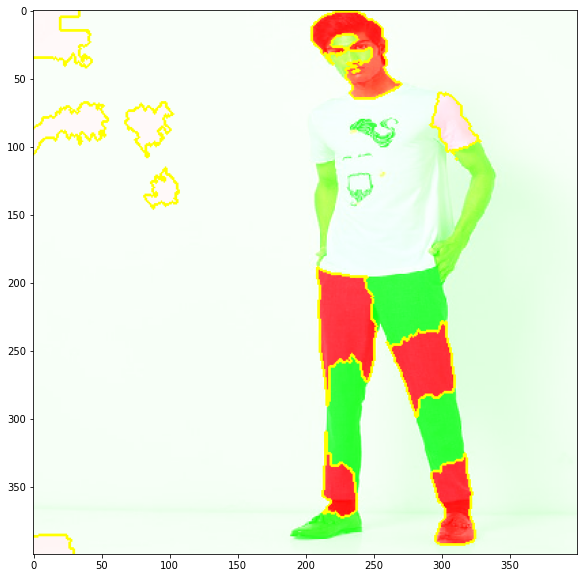

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

x = x.reshape(1,400,400,3)
result = loaded_model.predict(x)
print(result)
top = reverse_class_mapping[np.argmax(result,axis=1)[0]]
print(top)
print("********")
top_classes = result[0].argsort()[-5:][::-1]
for i in top_classes:
    print(reverse_class_mapping[i])

In [ ]:
## HEATMAP
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

## Testing the model

In [ ]:
import os
test_filenames=[]

for folder in os.listdir(main_dir+'tshirt_v2/test'):
    for item in os.listdir(main_dir+'tshirt_v2/test/'+folder):

        test_filenames.append(os.path.join(main_dir+'tshirt_v2/test/'+folder,item))

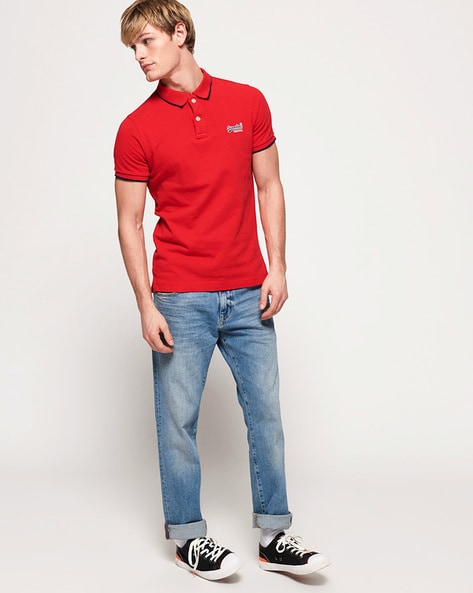

1/1 [==============================] - 0s 19ms/step
[[1.0175453e-01 6.3237763e-04 2.3829660e-01 3.1014064e-05 2.1723142e-02
  6.2484014e-01 1.0265873e-03 1.1695537e-02]]
full
cloth
back
front
sleeve
---------------------------------------------------------


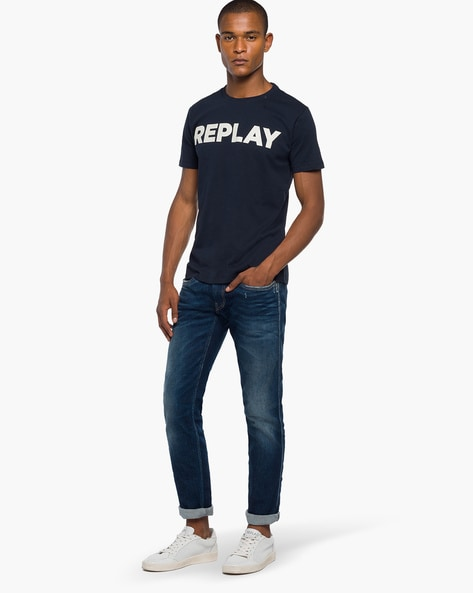

1/1 [==============================] - 0s 19ms/step
[[3.9184128e-05 6.8504496e-06 1.0964516e-02 2.4114308e-06 3.0405616e-04
  9.8866731e-01 1.4487984e-05 1.1774699e-06]]
full
cloth
front
back
side
---------------------------------------------------------


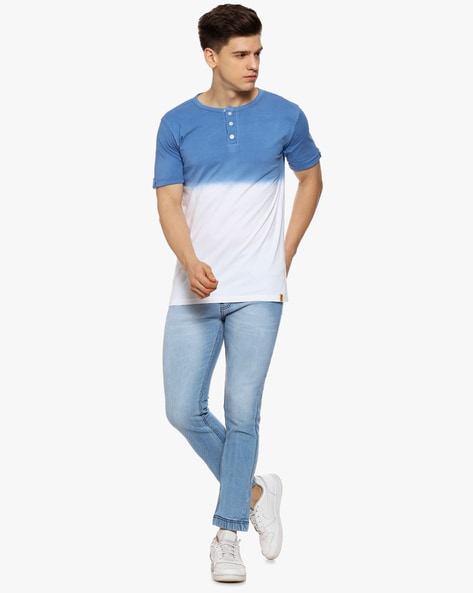

1/1 [==============================] - 0s 19ms/step
[[4.5103986e-02 8.7482622e-05 6.6678709e-04 7.5512062e-06 9.3062446e-03
  8.5794657e-01 8.6858042e-02 2.3363242e-05]]
full
side
back
front
cloth
---------------------------------------------------------


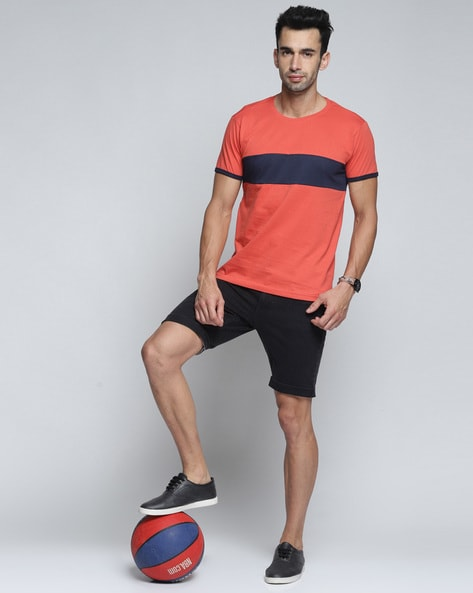

1/1 [==============================] - 0s 20ms/step
[[7.7330647e-04 2.8156463e-04 9.5701849e-01 2.5840965e-03 1.0599336e-03
  3.7785079e-02 1.4811336e-05 4.8270944e-04]]
cloth
full
collar
front
back
---------------------------------------------------------


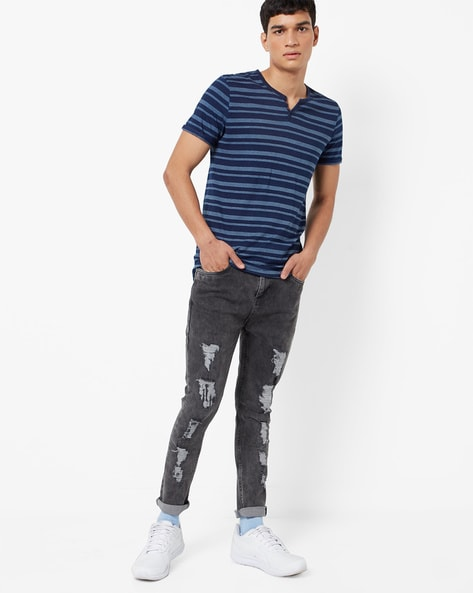

1/1 [==============================] - 0s 19ms/step
[[5.0301500e-05 5.6218389e-05 1.7194059e-01 1.3349568e-04 4.5135428e-04
  8.2722813e-01 1.1693833e-04 2.2949309e-05]]
full
cloth
front
collar
side
---------------------------------------------------------


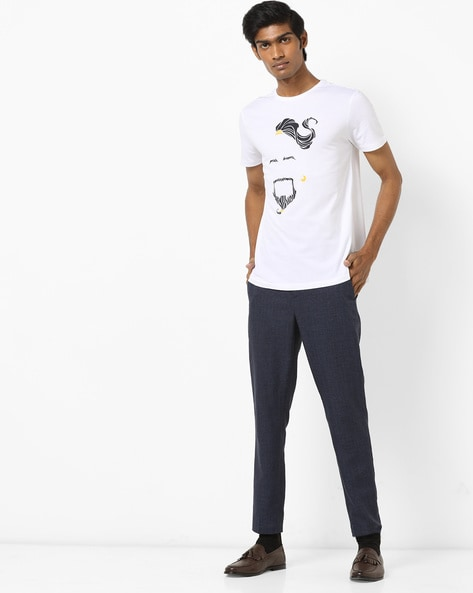

1/1 [==============================] - 0s 19ms/step
[[4.8665830e-04 1.6665800e-03 5.2015781e-01 2.7938229e-03 1.4892389e-03
  4.7247717e-01 6.8852646e-06 9.2190137e-04]]
cloth
full
collar
close-up
front
---------------------------------------------------------


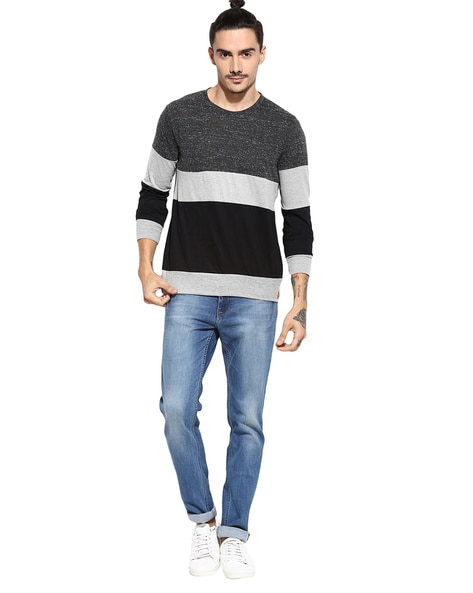

1/1 [==============================] - 0s 20ms/step
[[2.2592046e-04 1.3518285e-04 3.8390677e-02 6.5238714e-06 8.5049163e-04
  9.6009880e-01 2.8090525e-04 1.1503808e-05]]
full
cloth
front
side
back
---------------------------------------------------------


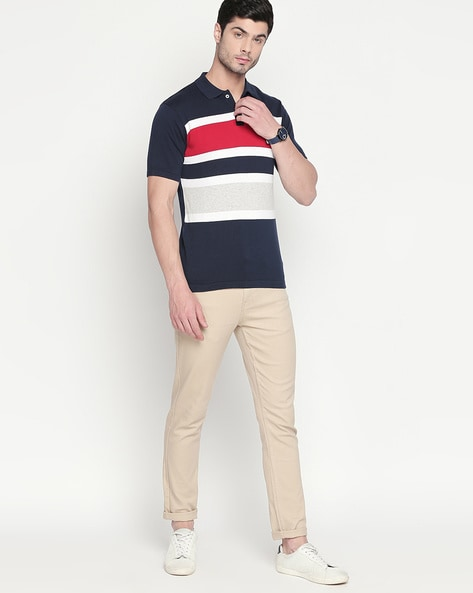

1/1 [==============================] - 0s 19ms/step
[[5.4256394e-05 1.0544803e-04 4.0760776e-01 2.3241760e-04 1.6519004e-04
  5.9178531e-01 7.4162170e-07 4.8843634e-05]]
full
cloth
collar
front
close-up
---------------------------------------------------------


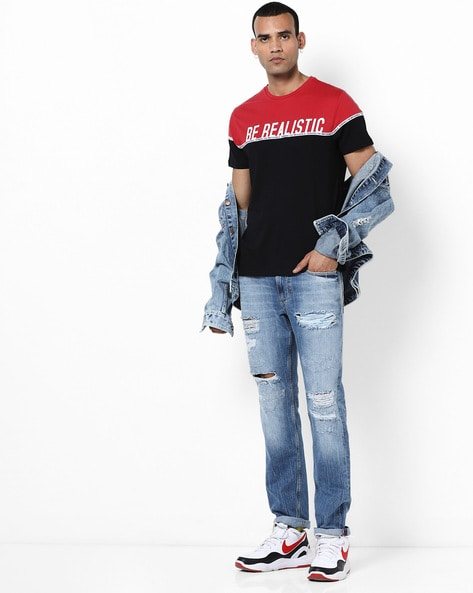

1/1 [==============================] - 0s 19ms/step
[[1.7702932e-03 8.3509332e-04 3.7431428e-01 1.2693537e-04 4.2642085e-03
  6.0714173e-01 1.0777434e-02 7.7001430e-04]]
full
cloth
side
front
back
---------------------------------------------------------


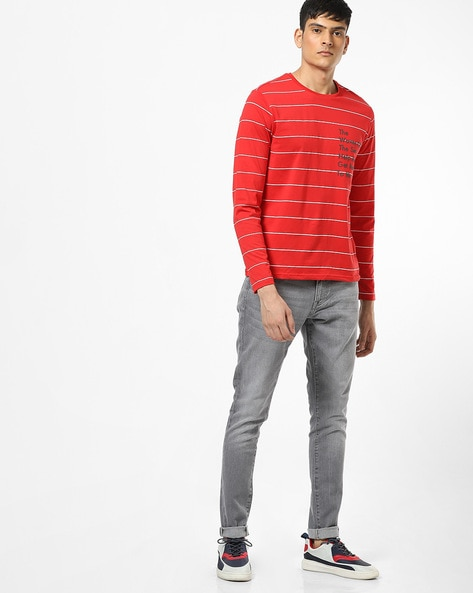

1/1 [==============================] - 0s 19ms/step
[[2.6649746e-04 1.4990462e-03 4.6137670e-01 4.3515554e-03 2.5441749e-03
  5.2782786e-01 9.8440156e-04 1.1497949e-03]]
full
cloth
collar
front
close-up
---------------------------------------------------------


In [ ]:
from google.colab.patches import cv2_imshow
from keras.applications.imagenet_utils import decode_predictions
import skimage
import cv2

for i in range(10):
    img = cv2.imread(test_filenames[i])
    cv2_imshow(img)
    image = cv2.resize(img,(400,400))
    image = image.reshape(1, 400,400,3)
    result = loaded_model.predict(image, verbose=1)
    print(result)
    top_classes = result[0].argsort()[-5:][::-1]
    for i in top_classes:
        print(reverse_class_mapping[i])
   
    print("---------------------------------------------------------")

## Testing with LIME Interpretation

In [ ]:
from tensorflow.keras.models import load_model
loaded_model = load_model('/content/drive/My Drive/ImageClassification/model3_20ep.h5')

In [ ]:
import os
test_filenames=[]

for folder in os.listdir(main_dir+'tshirt_v2/test'):
    for item in os.listdir(main_dir+'tshirt_v2/test/'+folder):
        test_filenames.append(os.path.join(main_dir+'tshirt_v2/test/'+folder,item))

In [ ]:
import random

random.shuffle(test_filenames)

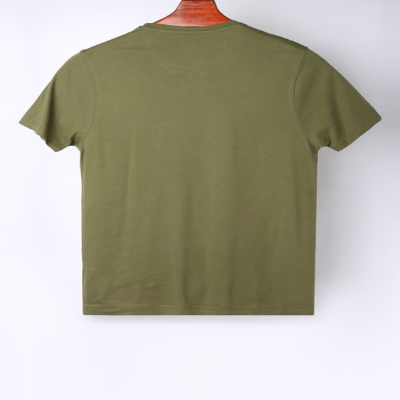

1/1 [==============================] - 0s 19ms/step
[[7.7796176e-07 2.3706941e-04 9.9782515e-01 1.1317632e-03 1.0358890e-06
  2.3590894e-05 7.4317144e-09 7.8056852e-04]]
cloth
collar
sleeve
close-up
full


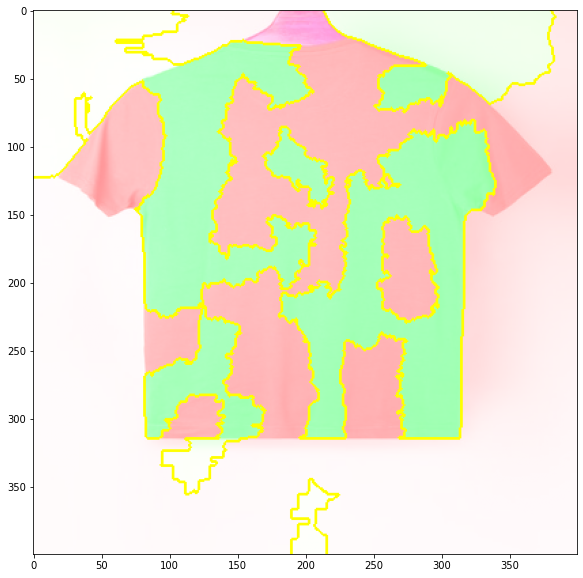

---------------------------------------------------------


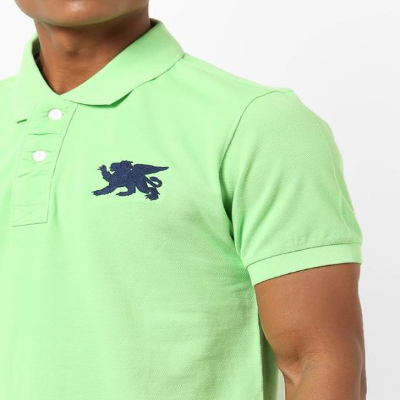

1/1 [==============================] - 0s 5ms/step
[[3.4401176e-04 1.5112408e-02 8.1390864e-01 1.5011522e-02 1.4727497e-04
  3.0937462e-04 3.3878541e-07 1.5516646e-01]]
cloth
sleeve
close-up
collar
back


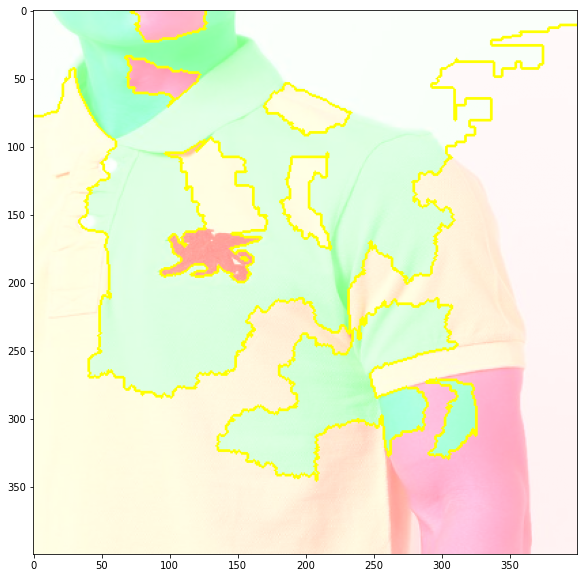

---------------------------------------------------------


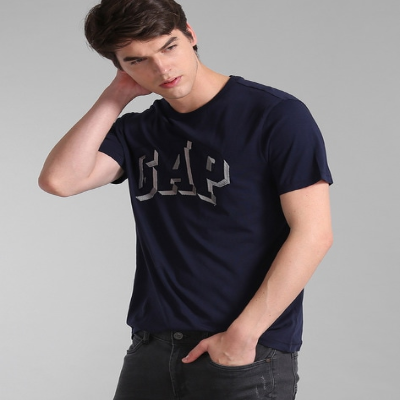

1/1 [==============================] - 0s 7ms/step
[[3.1027775e-03 4.0908144e-05 2.1822725e-01 2.3339077e-05 9.5127948e-02
  6.8313575e-01 2.2582822e-06 3.3968085e-04]]
full
cloth
front
back
sleeve


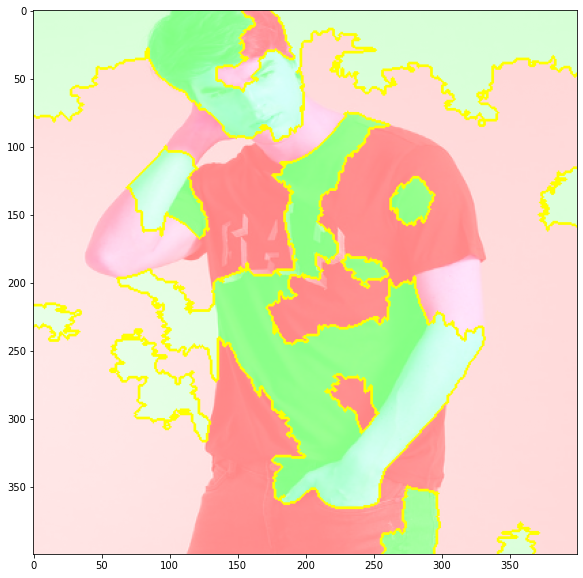

---------------------------------------------------------


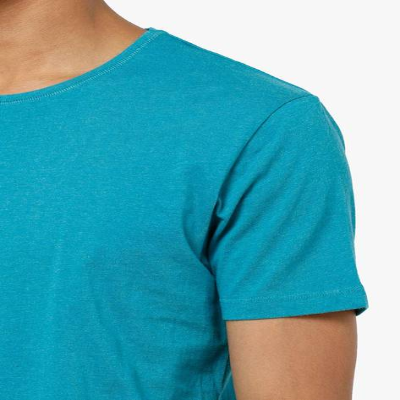

1/1 [==============================] - 0s 8ms/step
[[3.5656427e-04 3.6952761e-03 8.4413663e-03 7.9336815e-04 1.2446848e-04
  3.8292927e-07 2.6792279e-08 9.8658854e-01]]
sleeve
cloth
close-up
collar
back


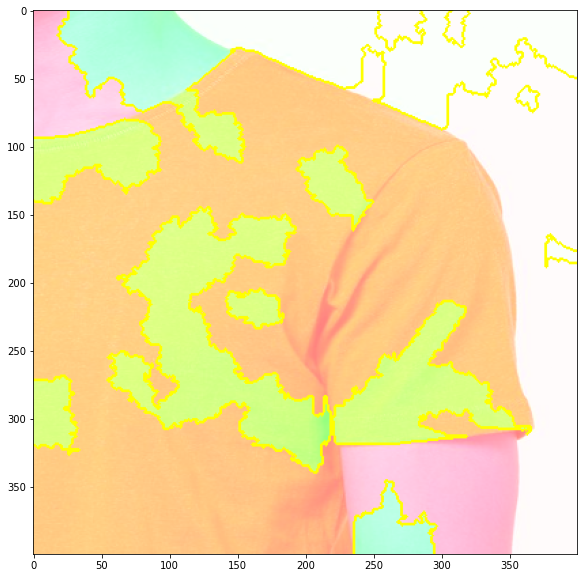

---------------------------------------------------------


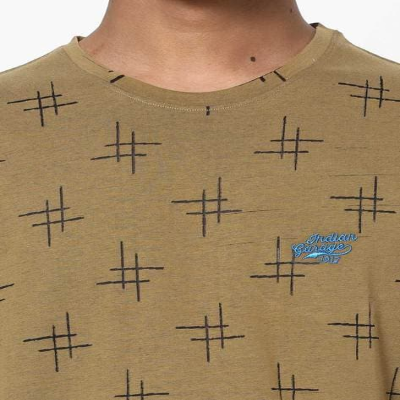

1/1 [==============================] - 0s 11ms/step
[[2.8768080e-05 9.8392092e-02 6.1550385e-01 8.3608195e-02 2.0175772e-05
  4.5352950e-05 1.2222848e-06 2.0240034e-01]]
cloth
sleeve
close-up
collar
full


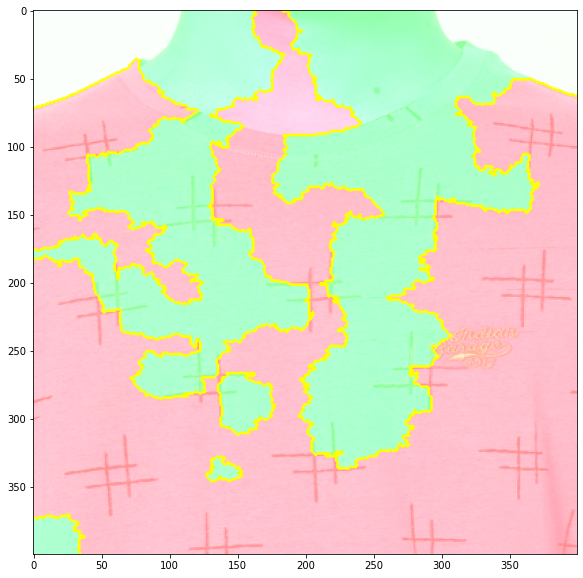

---------------------------------------------------------


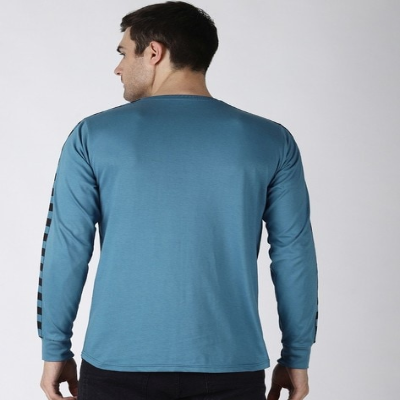

1/1 [==============================] - 0s 6ms/step
[[2.5087843e-02 6.1934981e-02 1.7429704e-02 1.3079726e-03 5.2418164e-04
  5.2726145e-06 7.0440512e-07 8.9370924e-01]]
sleeve
close-up
back
cloth
collar


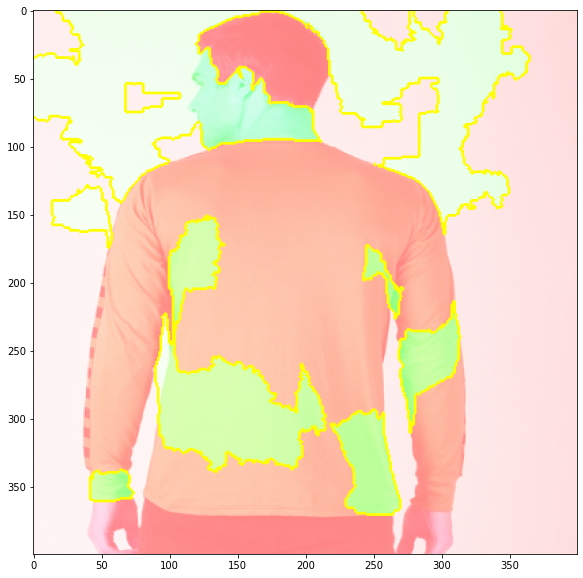

---------------------------------------------------------


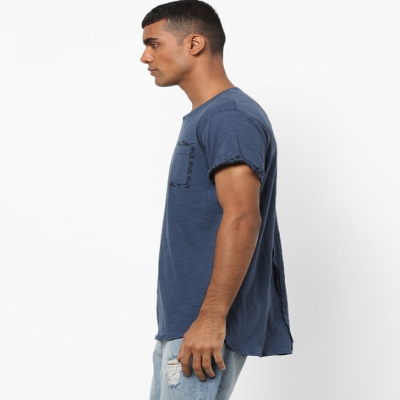

1/1 [==============================] - 0s 7ms/step
[[5.4287985e-03 8.2589831e-05 2.4836156e-01 3.8022728e-05 7.7342847e-03
  5.4921496e-01 1.8848781e-01 6.5194047e-04]]
full
cloth
side
front
back


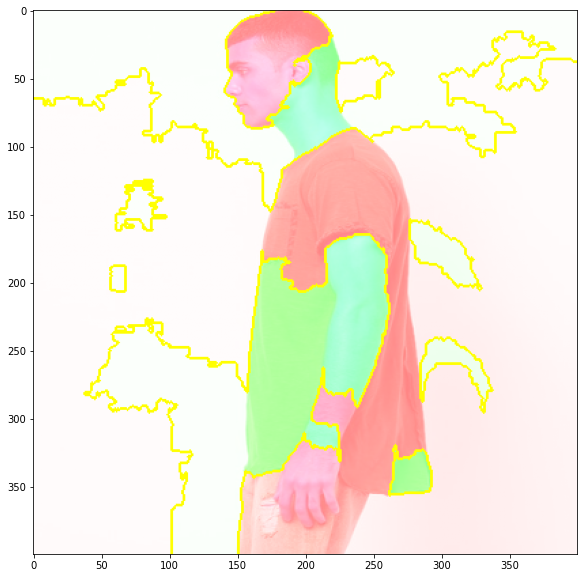

---------------------------------------------------------


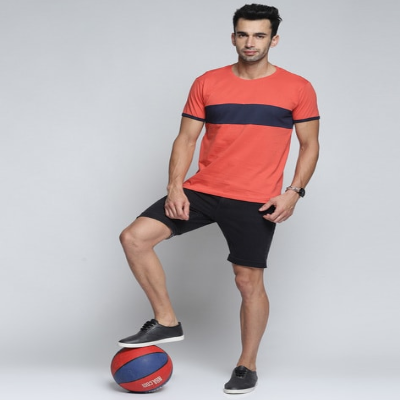

1/1 [==============================] - 0s 5ms/step
[[7.7330647e-04 2.8156463e-04 9.5701849e-01 2.5840965e-03 1.0599336e-03
  3.7785079e-02 1.4811336e-05 4.8270944e-04]]
cloth
full
collar
front
back


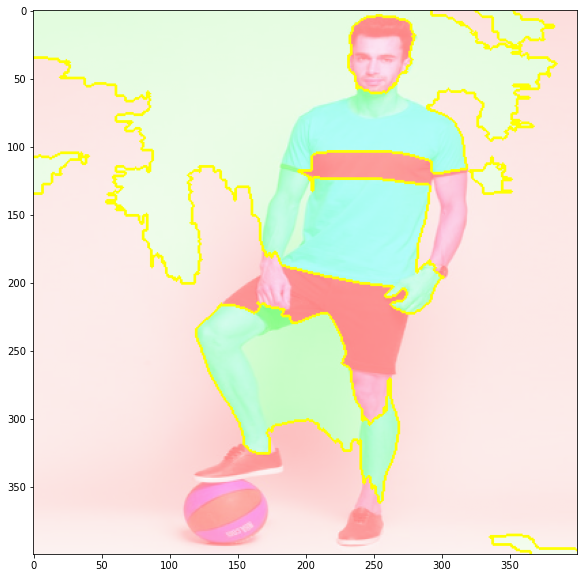

---------------------------------------------------------


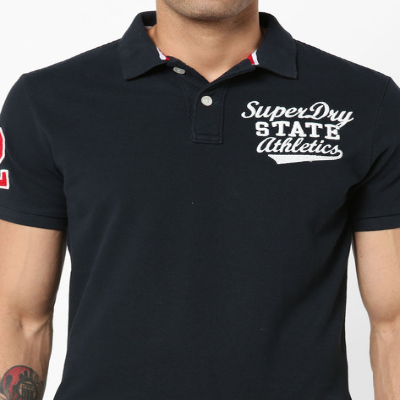

1/1 [==============================] - 0s 7ms/step
[[5.91031458e-05 3.30453724e-01 6.19194925e-01 3.96666452e-02
  2.84927828e-05 1.02794496e-04 1.37754219e-09 1.04943737e-02]]
cloth
close-up
collar
sleeve
full


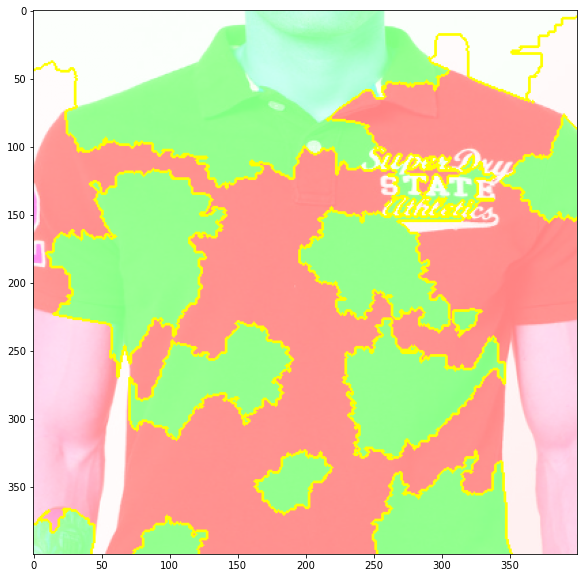

---------------------------------------------------------


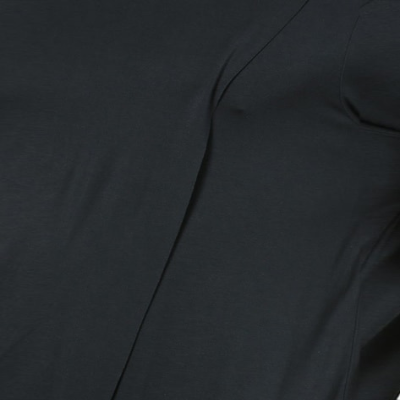

1/1 [==============================] - 0s 7ms/step
[[8.4770632e-05 2.5888013e-03 9.6465510e-01 1.3107652e-02 1.8313051e-05
  2.7105941e-03 5.9437869e-05 1.6775370e-02]]
cloth
sleeve
collar
full
close-up


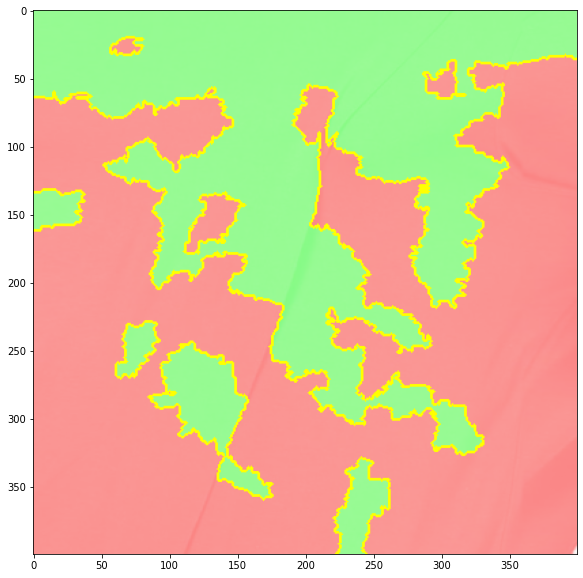

---------------------------------------------------------


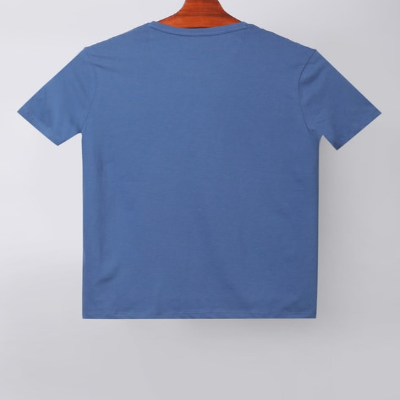

1/1 [==============================] - 0s 7ms/step
[[3.2604820e-04 2.5722650e-03 8.7845421e-01 1.0405149e-01 7.8701778e-05
  1.9049726e-04 1.0713248e-07 1.4326612e-02]]
cloth
collar
sleeve
close-up
back


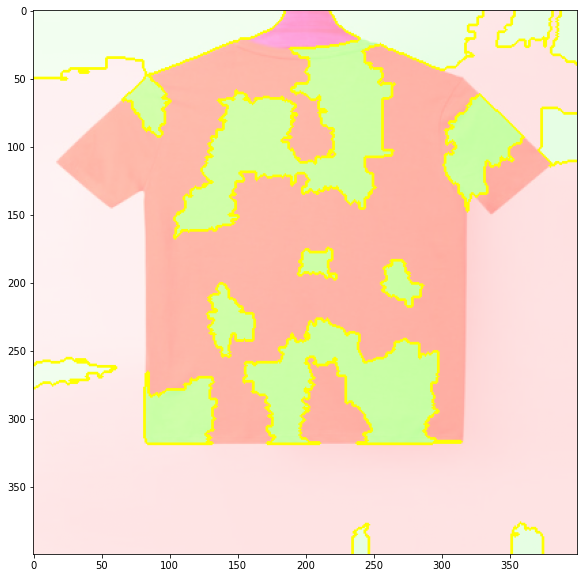

---------------------------------------------------------


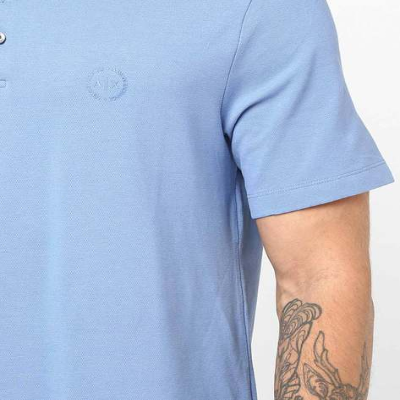

1/1 [==============================] - 0s 8ms/step
[[4.2969474e-04 6.5376349e-02 8.1468713e-01 7.0225969e-02 2.0915492e-07
  3.8340680e-08 3.7856013e-11 4.9280535e-02]]
cloth
collar
close-up
sleeve
back


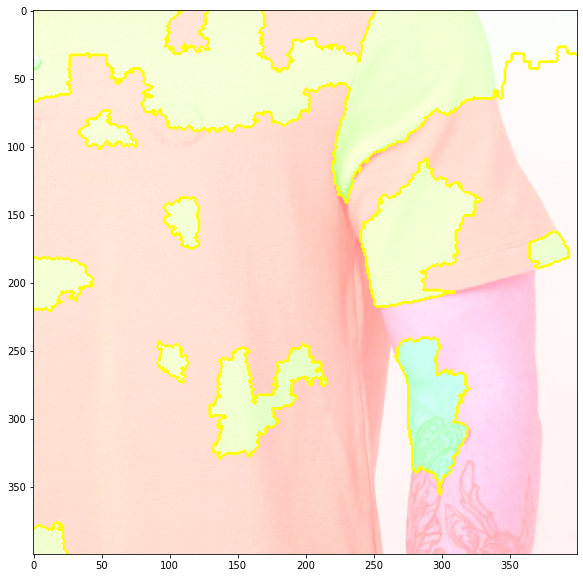

---------------------------------------------------------


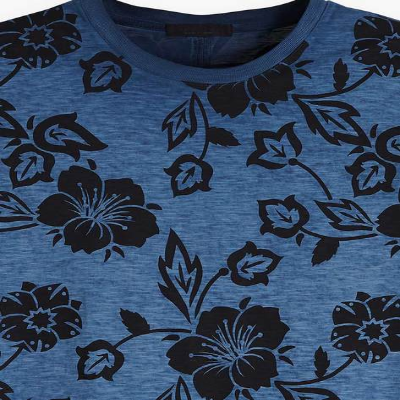

1/1 [==============================] - 0s 10ms/step
[[6.4634398e-05 6.2959057e-01 1.6974570e-02 2.7210152e-02 1.1031915e-04
  1.6024138e-07 2.7018872e-08 3.2604963e-01]]
close-up
sleeve
collar
cloth
front


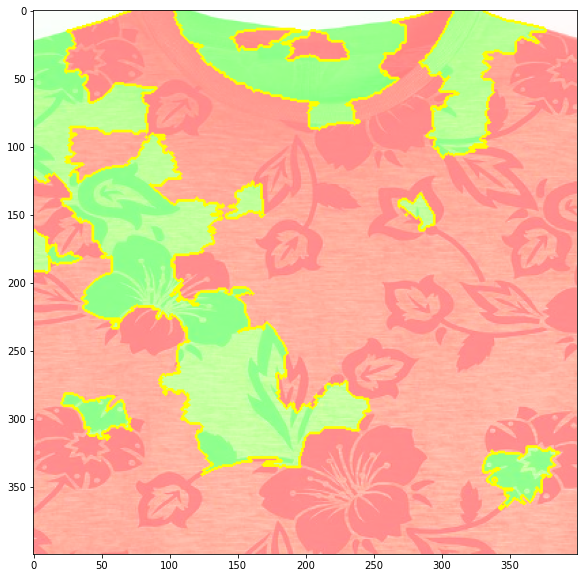

---------------------------------------------------------


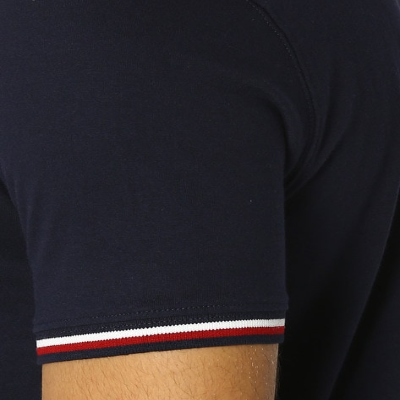

1/1 [==============================] - 0s 7ms/step
[[1.7242804e-04 2.9905350e-03 9.6330851e-01 1.6105808e-02 6.2206185e-05
  1.1616354e-03 3.7245787e-05 1.6161717e-02]]
cloth
sleeve
collar
close-up
full


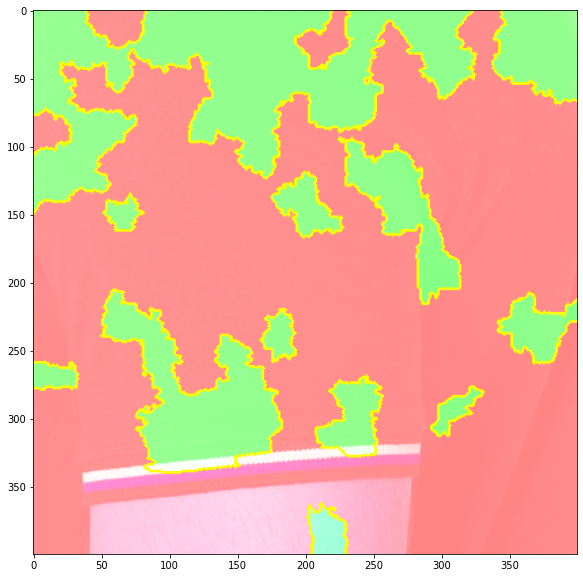

---------------------------------------------------------


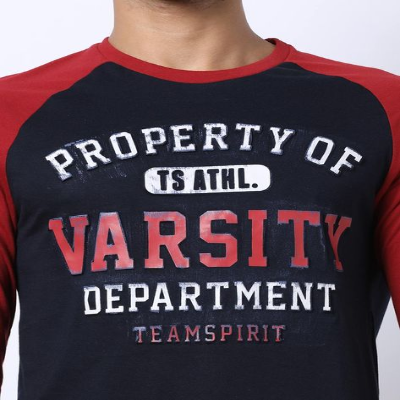

1/1 [==============================] - 0s 6ms/step
[[3.8717422e-05 3.4954321e-01 6.1161011e-01 1.2398860e-02 1.1623204e-05
  2.7114354e-06 3.4635248e-09 2.6394771e-02]]
cloth
close-up
sleeve
collar
back


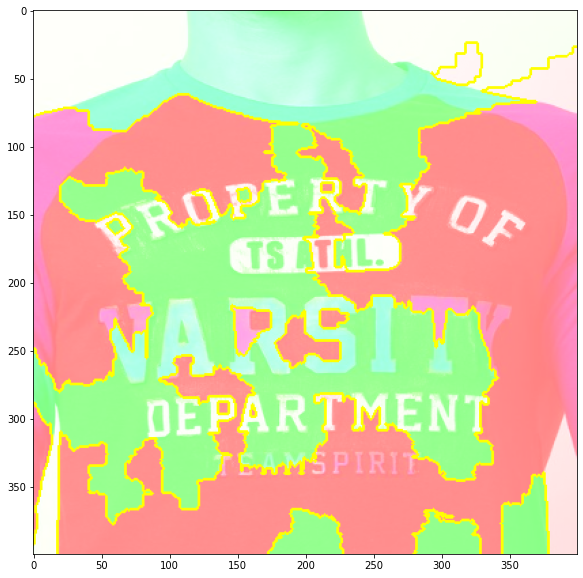

---------------------------------------------------------


In [ ]:
from google.colab.patches import cv2_imshow
from keras.applications.imagenet_utils import decode_predictions
import skimage
import cv2
import matplotlib.pyplot as plt

explainer = lime_image.LimeImageExplainer()

for i in range(15):
    img = cv2.imread(test_filenames[i])
    image = cv2.resize(img,(400,400))
    cv2_imshow(image)
    image = image.reshape(1, 400,400,3)
    #image = preprocess_input(image)
    result = loaded_model.predict(image, verbose=1)
    print(result)
    top_classes = result[0].argsort()[-5:][::-1]
    for i in top_classes:
        print(reverse_class_mapping[i])
    
    x = image.reshape(400,400,3) / 255

    explanation = explainer.explain_instance(x,
                                            loaded_model.predict, 
                                            top_labels=1,
                                            hide_color=0,
                                            num_samples=100)
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0],
                                            positive_only=False,
                                            num_features=2000,
                                            hide_rest=True)
    plt.figure(figsize=(10,10))
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
    plt.show()
    
    print("---------------------------------------------------------")

## Saving the model

In [ ]:
model1.save(main_dir+'model1_v2_20ep.h5')

# Annotation using pigeon-jupyter

## using pip install

In [ ]:
!pip3 install pigeon-jupyter

from pigeon import annotate

  Created wheel for pigeon-jupyter: filename=pigeon_jupyter-0.1.0-cp36-none-any.whl size=3866 sha256=3b2375a27f58baf1d2a2ba81609600a8991988c6d2f441a397d29eedafdfac1e
  Stored in directory: /root/.cache/pip/wheels/9c/e1/74/712f424efed3467a38edd654aedaad8e303e254a5a0fdbed49
Successfully built pigeon-jupyter


## Custom annotate with 8 choices

In [ ]:
from zipfile import ZipFile

main_dir = '/content/drive/My Drive/ImageClassification/'
zip = ZipFile(main_dir+'tshirt_images_v1.zip',mode='r')
zip.extractall()

In [ ]:
"""
import os
image_dir ='/content/tshirt_images_v1'
ann_imgs = os.listdir(image_dir)

ann_images =[]
for i in ann_imgs:
    ann_images.append(os.path.join(image_dir,i))

import json
h = open(main_dir+'image_names_v1.txt','w')
img_names={'images':ann_images}
h.write(json.dumps(img_names))
h.close()
"""

In [ ]:
import os
import json

k = open(main_dir+'image_names_v1.txt','r')
ann_images = k.readlines()[0]
ann_images = json.loads(ann_images)
ann_images = ann_images['images']

In [ ]:
import random
import functools
from IPython.display import display, clear_output
from ipywidgets import Button, Dropdown, HTML, HBox, IntSlider, FloatSlider, Textarea, Output

def annotate(examples,
             options=None,
             shuffle=False,
             include_skip=True,
             display_fn=display,
             include_back=True):
    """
    Build an interactive widget for annotating a list of input examples.
    Parameters
    ----------
    examples: list(any), list of items to annotate
    options: list(any) or tuple(start, end, [step]) or None
             if list: list of labels for binary classification task (Dropdown or Buttons)
             if tuple: range for regression task (IntSlider or FloatSlider)
             if None: arbitrary text input (TextArea)
    shuffle: bool, shuffle the examples before annotating
    include_skip: bool, include option to skip example while annotating
    display_fn: func, function for displaying an example to the user
    Returns
    -------
    annotations : list of tuples, list of annotated examples (example, label)
    """
    examples = list(examples)
    if shuffle:
        random.shuffle(examples)

    annotations = []
    current_index = -1

    def set_label_text():
        nonlocal count_label
        count_label.value = '{} examples annotated, {} examples left'.format(
            len(annotations), len(examples) - current_index
        )

    def show_next():
        nonlocal current_index
        current_index += 1
        set_label_text()
        if current_index >= len(examples):
            for btn in buttons:
                btn.disabled = True
            print('Annotation done.')
            return
        with out:
            clear_output(wait=True)
            display_fn(examples[current_index])

    def show_back():
        nonlocal current_index
        current_index -= 1
        set_label_text()
        if current_index < 0:
            for btn in buttons:
                btn.disabled = True
            print('Cannot go back')
            return
        with out:
            clear_output(wait=True)
            display_fn(examples[current_index])

    def add_annotation(annotation):
        annotations.append((examples[current_index], annotation))
        show_next()

    def skip(btn):
        show_next()
    
    def behind(btn):
        show_back()

    count_label = HTML()
    set_label_text()
    display(count_label)

    if type(options) == list:
        task_type = 'classification'
    elif type(options) == tuple and len(options) in [2, 3]:
        task_type = 'regression'
    elif options is None:
        task_type = 'captioning'
    else:
        raise Exception('Invalid options')

    buttons = []
    
    if task_type == 'classification':
        use_dropdown = len(options) > 12

        if use_dropdown:
            dd = Dropdown(options=options)
            display(dd)
            btn = Button(description='submit')
            def on_click(btn):
                add_annotation(dd.value)
            btn.on_click(on_click)
            buttons.append(btn)
        
        else:
            for label in options:
                btn = Button(description=label)
                def on_click(label, btn):
                    add_annotation(label)
                btn.on_click(functools.partial(on_click, label))
                buttons.append(btn)

    elif task_type == 'regression':
        target_type = type(options[0])
        if target_type == int:
            cls = IntSlider
        else:
            cls = FloatSlider
        if len(options) == 2:
            min_val, max_val = options
            slider = cls(min=min_val, max=max_val)
        else:
            min_val, max_val, step_val = options
            slider = cls(min=min_val, max=max_val, step=step_val)
        display(slider)
        btn = Button(description='submit')
        def on_click(btn):
            add_annotation(slider.value)
        btn.on_click(on_click)
        buttons.append(btn)

    else:
        ta = Textarea()
        display(ta)
        btn = Button(description='submit')
        def on_click(btn):
            add_annotation(ta.value)
        btn.on_click(on_click)
        buttons.append(btn)

    if include_skip:
        btn = Button(description='skip')
        btn.on_click(skip)
        buttons.append(btn)
    if include_back:
        btn = Button(description='go_back')
        btn.on_click(behind)
        buttons.append(btn)
    box = HBox(buttons)
    display(box)

    out = Output()
    display(out)

    show_next()

    return annotations

In [ ]:
from IPython.display import display, Image
annotations = annotate(ann_images[100:200], 
                   options=['front','back','side','full','close-up', 'cloth'],
                       display_fn=lambda filename:display(Image(filename)))

HTML(value='0 examples annotated, 101 examples left')

Output()

Annotation done.


In [ ]:
import json
print(annotations)

if not os.path.exists(main_dir+'annotations_v2'):
    os.mkdir(main_dir+'annotations_v2')
data ={'data':annotations}
f = open(main_dir+'annotations_v2/annotations_2.txt','w')
f.write(json.dumps(data))
f.close()

[('/content/tshirt_images_v1/2996_0.jpg', 'full'), ('/content/tshirt_images_v1/2185_5.jpg', 'close-up'), ('/content/tshirt_images_v1/5042_1.jpg', 'close-up'), ('/content/tshirt_images_v1/6257_3.jpg', 'full'), ('/content/tshirt_images_v1/2398_4.jpg', 'full'), ('/content/tshirt_images_v1/3534_0.jpg', 'close-up'), ('/content/tshirt_images_v1/7654_2.jpg', 'cloth'), ('/content/tshirt_images_v1/6203_2.jpg', 'close-up'), ('/content/tshirt_images_v1/7198_0.jpg', 'front'), ('/content/tshirt_images_v1/7277_1.jpg', 'cloth'), ('/content/tshirt_images_v1/4385_2.jpg', 'front'), ('/content/tshirt_images_v1/3249_2.jpg', 'close-up'), ('/content/tshirt_images_v1/1339_3.jpg', 'front'), ('/content/tshirt_images_v1/5967_2.jpg', 'front'), ('/content/tshirt_images_v1/9381_3.jpg', 'full'), ('/content/tshirt_images_v1/8602_0.jpg', 'front'), ('/content/tshirt_images_v1/4939_0.jpg', 'cloth'), ('/content/tshirt_images_v1/738_3.jpg', 'back'), ('/content/tshirt_images_v1/603_0.jpg', 'cloth'), ('/content/tshirt_imag

In [ ]:
cat = []

for i in annotations_1:
    cat.append(i[1])
import pandas as pd
cat_pd = pd.Categorical(cat) 
print(cat_pd.value_counts())

back        18
close-up     4
cloth       13
collar       6
front       31
full        13
side         9
sleeve       3
dtype: int64


In [ ]:
 ann_14 = []
 
 for i in range(1,35):
    g = open(main_dir+'annotations/annotations_'+str(i)+'.txt','r')
    dataa = g.readlines()
    dataa = dataa[0]
    dataa = jsototal_ann[i]n.loads(dataa)['data']
    ann_14+=dataa

In [ ]:
cat = []

for i in ann_14:
    cat.append(i[1])
import pandas as pd
cat_pd = pd.Categorical(cat) 
print(cat_pd.value_counts())

back        586
close-up    286
cloth       580
collar      245
front       874
full        422
none          2
side        213
sleeve      190
dtype: int64
